In [ ]:
  ! pip install lightning-bolts
  ! pip install torchsummary
  ! pip install umap-learn

In [ ]:
import os

from lib_CM import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim.lr_scheduler import OneCycleLR
from pytorch_lightning.callbacks import EarlyStopping
from torchmetrics.functional import accuracy
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models._utils import IntermediateLayerGetter

seed_everything(333)

Global seed set to 333


333

In [ ]:
from torchvision import models
def get_available_models():

    return [
        k
        for k, v in models.__dict__.items()
        if callable(v) and k[0].lower() == k[0] and k[0] != "_" and k != "get_weight"
    ]
get_available_models()

In [ ]:
#PATH_DATASET = "/project/code/adish/data/classification_data"
PATH_DATASET = "/project/code/Ravi Gautam/car_damage_data/"
# ! rmdir /project/code/adish/data/classification_data/train/.ipynb_checkpoints
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 32 if AVAIL_GPUS else 16
NUM_WORKERS = int(os.cpu_count() / 2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def prepare_backbone(backbone='mobilenet', use_pretrained=True):

    if backbone == "mobilenet":
        model = torchvision.models.mobilenet_v2(pretrained=use_pretrained)
    elif backbone == "resnet18":
        model = torchvision.models.resnet18(pretrained=use_pretrained)
    elif backbone == "vgg16":
        model = torchvision.models.vgg16(pretrained=use_pretrained)
    elif backbone == "effnet0":
        model = torchvision.models.efficientnet_b0(pretrained=use_pretrained)

    model = create_feature_extractor(model, return_nodes=["flatten"] )

    return model

def get_feature_dims(backbone):
    inp = torch.randn(2, 3, 224, 224)
    with torch.no_grad():
        out = backbone(inp)
    in_channels_list = [o.shape[1] for o in out.values()]
    return in_channels_list[0]

In [ ]:
class CustomClassifier(LightningModule):
    def __init__(self, lr=0.05, num_clusters=3, num_classes = 3):
        super().__init__()

        self.save_hyperparameters()
        self.lr = lr
        self.model = prepare_backbone("mobilenet")
        latent_dim=10
        num_classes=num_classes
        feature_dim = get_feature_dims(self.model)
        self.BETA=1.5
        self.ALPHA=1.1
        self.LBD=0.1
        self.cm_loss=Clustering_Module_Loss(
                        num_clusters=num_clusters,
                        alpha=self.ALPHA,
                        lbd=self.LBD,
                        orth=True,
                        normalize=True)
        self.latent_layer = nn.Linear(feature_dim, latent_dim)
        self.classifier = nn.Sequential(nn.Linear(latent_dim, int(feature_dim/2)),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(int(feature_dim/2), 64),
                                nn.ReLU(),
                                nn.Dropout(0.3),
                                nn.Linear(64, num_classes))
        self.cm=Clustering_Module(latent_dim, num_clusters, False)

    def forward(self, x):
        x=self.model(x)
        x=x["flatten"]
        x_latent = self.latent_layer(x)
        # x = self.classifier(x)
        return F.log_softmax(self.classifier(x_latent), dim=1),self.cm(x_latent),x_latent

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits,cm_out,_ = self(x)
        loss_clf = F.nll_loss(logits, y)
        loss_cm=self.cm_loss(cm_out)
        loss=loss_clf*self.BETA+loss_cm
        print("classifier loss: {}, cm loss: {}".format(loss_clf,loss_cm))
        # self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        # logits = self(x)
        # loss = F.nll_loss(logits, y)
        logits,cm_out,_ = self(x)
        loss_clf = F.nll_loss(logits, y)
        loss_cm=self.cm_loss(cm_out)
        loss=loss_clf*self.BETA+loss_cm
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        steps_per_epoch = 45000 // BATCH_SIZE
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

In [ ]:
def data_transforms(transform_type ='train'):
    if transform_type=='train':
        transforms_ret = transforms.Compose([
                                    transforms.RandomResizedCrop(256,scale=(0.8, 1.0),ratio=(0.75, 1.33)),
                                    transforms.RandomRotation(degrees=15),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    # transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                   ])
    else:
        transforms_ret = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                # transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                              ])
    return transforms_ret

def prepare_data(train_dir,test_dir):

    train_dataset = torchvision.datasets.ImageFolder(train_dir,
                                                     transform=data_transforms(transform_type='train'))
    val_dataset = torchvision.datasets.ImageFolder(val_dir,
                                                   transform=data_transforms(transform_type='val'))

    class_names = train_dataset.classes

    print("len of train and val dataset : \n")
    print(len(train_dataset),len(val_dataset))
    print("class names : \n")
    print(class_names)
    return train_dataset,val_dataset

def create_dataloader(dataset):
    loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle = True
    )
    return loader


train_dir = os.path.join(PATH_DATASET, "train")
val_dir = os.path.join(PATH_DATASET, "val")

train_dataset, val_dataset = prepare_data(train_dir,val_dir)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = True, num_workers=NUM_WORKERS)

In [ ]:
model = CustomClassifier(lr=3e-4, num_clusters=3, num_classes=3)
early_stopping = EarlyStopping(monitor = 'val_loss', patience=20)
trainer = Trainer(gpus=1, max_epochs=100, callbacks=[early_stopping], checkpoint_callback=True)
trainer.fit(model=model,train_dataloaders=train_dataloader,val_dataloaders=val_dataloader)
trainer.test(model, val_dataloader)

In [ ]:
trainer.save_checkpoint("mobClfCMLD10_2709.ckpt")

# model_scripted = torch.jit.script(model.model) # Export to TorchScript
# model_scripted.save("models/efficientnet_b0.pt") # Save

In [ ]:
#EXP_NAME = 'mobClfCMLD0506_0108'
EXP_NAME = 'mobClfCMLD10_2709'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tforms = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                # transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                              ])


model = CustomClassifier.load_from_checkpoint(EXP_NAME+".ckpt")
model.eval()
model.to(device)

In [ ]:
class Hook():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

hook = Hook(model.latent_layer)

In [ ]:
from PIL import Image
import numpy as np

metadata = []
embeddings = []
cm_pred =[]
sprites = []
impath = []
imname = []
#rootdir="/project/code/adish/data/classification_data/train"
#rootdir="project/datasets/BDD/bdd100k_crops/new_names/dataset_high_quality_images/balanced_dataset/val"
#rootdir = "/project/code/adish/data/latest_data/train"
rootdir="/project/code/Ravi Gautam/car_damage_data/train"
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".jpg"):
            img = Image.open(filepath)
            #gnd_class = filepath.split("dataset")[-1].split("_")[1]
            gnd_class = filepath
            #print (gnd_class[46:50])
            print (gnd_class[48:52])
            #print (filepath)
            img1 = tforms(img)
            img1 = img1.unsqueeze(0)
            img1 = torch.autograd.Variable(img1, requires_grad=False).to(device)
            output= model(img1)
            np_out = hook.output.cpu().detach().numpy()[0]
            img = img.resize((224,224))
            #"car", "person", "truck", "traffic_light", "motor"]
            embeddings.append(np_out) #embeddings here
            if gnd_class[48:52] == 'dent':
                metadata.append('dent')
            if gnd_class[48:52] == 'good':
                metadata.append('good')
            if gnd_class[48:52] == 'scra':
                metadata.append('scratch')

            sprites.append(img)
            cm_pred.append(output[1][1].argmax().item())
            impath.append(filepath)

In [ ]:
#impath
LOG_DIR = 'tensorboard_10_2709'
#os.mkdir(LOG_DIR)
with open(f'{LOG_DIR}/image_name_val.tsv', 'w') as file:
    for name in impath:
        file.write(f'{name}\n')

In [ ]:
#impath

In [ ]:
#import shutil
#shutil.rmtree('/project/code/nandan/Experiments/Achene_Joint_Opt_AECM_paper  /BDD_CM/MobClfCM_LD/tensorboard_0506')

In [ ]:
import csv

LOG_DIR = 'tensorboard_10_2709'
#os.mkdir(LOG_DIR)
with open(f'{LOG_DIR}/tensors.tsv', 'w') as fw:
    csv_writer = csv.writer(fw, delimiter='\t')
    csv_writer.writerows(embeddings)

with open(f'{LOG_DIR}/metadata.tsv', 'w') as file:
    for name in metadata:
        file.write(f'{name}\n')

with open(f'{LOG_DIR}/cm_pred.tsv', 'w') as file:
    for name in cm_pred:
        file.write(f'{name}\n')


one_square_size = int(np.ceil(np.sqrt(len(sprites))))
master_width = 64 * one_square_size
master_height = 64 * one_square_size
spriteimage = Image.new(
    mode='RGBA',
    size=(master_width, master_height),
    color=(0,0,0,0) # fully transparent
)
for count, image in enumerate(sprites):
    div, mod = divmod(count, one_square_size)
    h_loc = 224 * div
    w_loc = 224 * mod
    spriteimage.paste(image, (w_loc, h_loc))
spriteimage.convert('RGB').save(f'{LOG_DIR}/sprite.jpg', transparency=0)

print(len(embeddings))
print(len(metadata))
print(len(sprites))
print(len(cm_pred))

encoded_images = np.array(embeddings)
encoded_images.shape

78
78
78
78


(78, 10)

In [ ]:
len(embeddings[0])

10

In [ ]:
from scipy.optimize import linear_sum_assignment

def accuracy(y_true, y_pred):
    assert y_pred.shape[0] == y_true.shape[0]

    D = int( max(y_pred.max(), y_true.max()) + 1 )
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.shape[0]):
        w[int(y_pred[i]), int(y_true[i])] += 1
    ind = np.vstack(linear_sum_assignment(w.max() - w)).T
    acc =  sum([w[i, j] for i, j in ind]) * 1.0 / np.prod(y_pred.shape)
    return acc

In [ ]:
Lb=np.asarray(metadata)
Lb[ Lb == 'dent' ] = 0
Lb[ Lb == 'good' ] = 1
Lb[ Lb == 'scratch' ] = 2

Lb=Lb.astype(np.int32)

In [ ]:
from PIL import Image
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans


xun=embeddings
kmeans = KMeans(5 , init = 'k-means++', random_state=0)
y_kmeans = kmeans.fit_predict(xun)

print(metrics.adjusted_rand_score(Lb,y_kmeans))
print(metrics.adjusted_mutual_info_score(Lb, y_kmeans,  average_method='arithmetic'))
print(accuracy(Lb, y_kmeans))

0.4262362544495754
0.4038594852839839
0.5897435897435898


In [ ]:
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler

embed_dimesion=2
reducer = umap.UMAP(n_components=embed_dimesion)
embeddings_data1 = xun
#embeddings_data2 = embed_z_hat
scaled_embeddings_data1 = StandardScaler().fit_transform(embeddings_data1)
#scaled_embeddings_data2 = StandardScaler().fit_transform(embeddings_data2)
embed1 = reducer.fit_transform(scaled_embeddings_data1)
#embed2 = reducer.fit_transform(scaled_embeddings_data2)

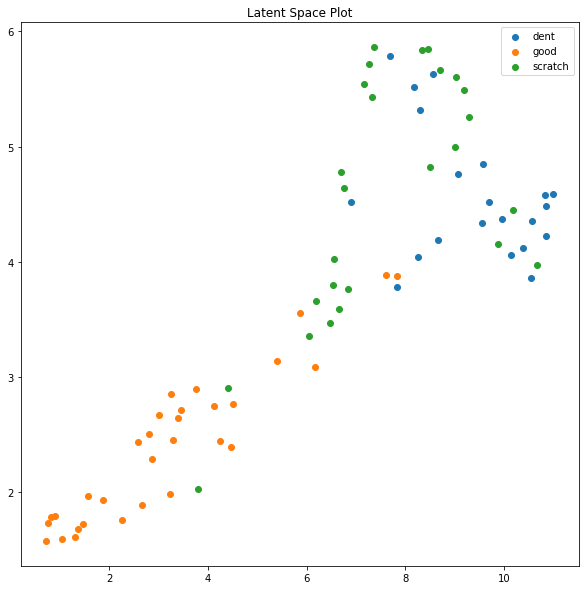

In [ ]:
#f = plt.figure()
f, ax = plt.subplots()
f.set_figwidth(10)
f.set_figheight(10)
plt.title("Latent Space Plot")
labels = {0:'dent',1:'good',2:'scratch'}

for g in np.unique(Lb):
    ix = np.where(Lb == g)[0]
    ax.scatter(embed1[ix,0], embed1[ix,1], label = labels[g])
ax.legend()
plt.show()

#plt.scatter(embed1[:,0],embed1[:,1],c=Lb)
#plt.legend()
#plt.show()

In [ ]:
xun=np.asarray(embed1.tolist())

kmeans = KMeans(5 , init = 'k-means++', random_state=0)
y_kmeans = kmeans.fit_predict(xun)

print(metrics.adjusted_rand_score(Lb,y_kmeans))
print(metrics.adjusted_mutual_info_score(Lb, y_kmeans,  average_method='arithmetic'))
print(accuracy(Lb, y_kmeans))

0.66320176036768
0.7913143812188215
0.6797752808988764


In [ ]:
cm_pred = np.asarray(cm_pred)

print(metrics.adjusted_rand_score(Lb,cm_pred))
print(metrics.adjusted_mutual_info_score(Lb, cm_pred,  average_method='arithmetic'))
print(accuracy(Lb, cm_pred))

0.9553623582645275
0.9390599431493275
0.9831460674157303


In [ ]:
import os
os.getcwd()

'/project/code/nandan/Experiments/Car_Dent'

In [ ]:
cm_pred
unique, counts = np.unique(cm_pred, return_counts=True)

In [ ]:
dict(zip(unique, counts))

{0: 70, 1: 45, 2: 63}

In [ ]:
unique, counts = np.unique(metadata, return_counts=True)
dict(zip(unique, counts))

{'dent': 48, 'good': 70, 'scratch': 60}

In [ ]:
import pandas as pd

dfInf = pd.DataFrame(list(zip(cm_pred, metadata)),
              columns=['cm_pred','metadata'])

In [ ]:
df2 = dfInf.groupby(['cm_pred', 'metadata'])['metadata'].count()
df2

cm_pred  metadata
0        good        70
1        dent        45
2        dent         3
         scratch     60
Name: metadata, dtype: int64

In [ ]:
pd.set_option('display.max_rows', None)
print (dfInf[dfInf['cm_pred']== 8])

Empty DataFrame
Columns: [cm_pred, metadata]
Index: []


In [ ]:
labels = []
file_paths = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith(".png"):
            labels.append(filepath.split("/")[7])
            file_paths.append(filepath)

In [ ]:
import json
import numpy as np
import pandas as pd

In [ ]:
with open('weather.json', 'r') as f:
    weath = json.load(f)

In [ ]:
np.array(weath['root_dir/eventVideo_sensor_Harsh-Braking_trip_master_2022_03_01_10_06_37_617_ED6C1DCD50AF9ADC958A17E2DF85C2141187EC11_oYkLS_33_2022_03_01_13_30_50_805_primary/31.jpg']['embedding']).shape

(2048,)

In [ ]:
df = {'filepath':[], 'label':[], 'pred': [], 'embeddings': []}
for key in weath.keys():
    df['filepath'].append(key)
    df['label'].append(weath[key]['pred_class'])
    df['pred'].append(weath[key]['pred_class'])
    df['embeddings'].append(weath[key]['embedding'])

In [ ]:
cls = set({})
for key in weath.keys():
    cls.add(weath[key]['pred_class'])
cls

{'overcast', 'snowy', 'undefined'}